
# Diseño de software para cómputo científico

----

## Unidad 3: Object Relational Mappers

## Python + RBMS

```python
import MySQLdb
db = MySQLdb.connect(host='localhost',user='root',
                     passwd='',db='Prueba')
cursor = db.cursor()
cursor.execute('Select * From usuarios')
resultado = cursor.fetchall()
print('Datos de Usuarios')
for registro in resultado:
    print(registro[0], '->', registro[1])
```

**out**

```console
Datos de Usuarios
USU01 -> Young Neil
USU02 -> Knives Chau
```

## Como estamos?

- Si te gusta *SQL*.
- Pero *SQL* no esta implementado igual en los distintos motores.
- Y nada garantiza que ese motor no cambie con el tiempo (sobre todo en empresas
  grandes donde el que decide poco tiene que ver con el desarrolla)
- Lo que devuelve los conectores son set de datos y no objetos ``User``
  propiamente.
- La diferencias entre el modelo de objetos y relacional.
- Pero esto es rápido.


## Que opciones tenemos?

- Usar ORM

    El mapeo objeto-relacional  es una
    técnica de programación para convertir datos entre el sistema de tipos
    utilizado en un lenguaje de programación OO y el utilizado
    en una base de datos relacional, utilizando un motor de persistencia. En la
    práctica esto crea una base de datos orientada a objetos virtual, sobre la
    base de datos relacional. Esto posibilita el uso de las características
    propias de la orientación a objetos (básicamente herencia y polimorfismo)

`Wikipedia: ORM <http://es.wikipedia.org/wiki/Mapeo_objeto-relacional>`_

- Alternativas en Pyhon: SqlAlchemy, Storm, **Peewee**, Django-ORM

## Una evidencia de la diferencia de modelos

Si necesitamos modelar la lógica **un usuario tiene muchos autos.**, y trataramos de extraer todos los autos por usuario.

- En diagramas Entity-Relational (ER) - Modelo Relacional

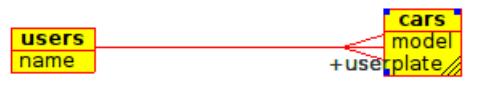

```python
c_x_u = {}
for c in cars:
    if c.user not in c_x_u:
        c_x_u[c.user] = []
    c_x_u[c.user].append(c)
```
    
- En diagrama de Clases - Modelo OO

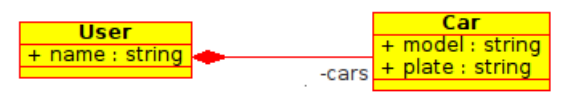

```python
c_x_u = {u: u.cars for u in user}
```



## Vamos con **Peewee**


- No es el mejor orm que existe (SQLAlchemy es el mejor que existe, pero no tenemos 3 hs).
- Es Django-like.
- Lo he usando para ordenar datos data minining y varias otras cosas.
- http://docs.peewee-orm.com/

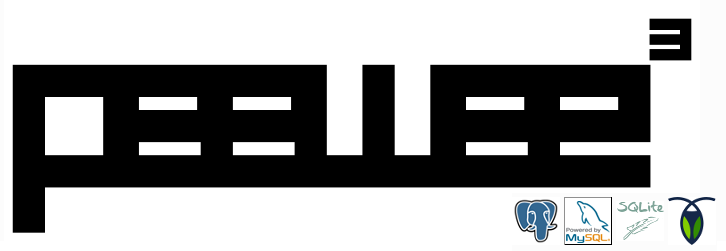



Declarando las tablas y las clases
----------------------------------

In [1]:
!pip install peewee

In [2]:
from peewee import *
example_db = SqliteDatabase('03_orm/example.db')

class ExampleModel(Model):
    class Meta:
        database = example_db

class User(ExampleModel):
    name = CharField()
    age = IntegerField()

class Car(ExampleModel):
    model = CharField(null=True)
    plate = CharField(unique=True)
    user = ForeignKeyField(User, related_name="cars")

User.create_table(fail_silently=True)
Car.create_table(fail_silently=True)

Un poco mas de los Fields
-------------------------

* ``null=False``: boolean indicating whether null values are allowed to be
  stored
* ``index=False``: boolean indicating whether to create an index on this column
* ``unique=False``: boolean indicating whether to create a unique index on this
  column
* ``verbose_name=None``: string representing the "user-friendly" name of this
  field
* ``help_text=None``: string representing any helpful text for this field
* ``db_column=None``: string representing the underlying column to use if
  different, useful for legacy databases
* ``default=None``: any value to use as a default for uninitialized models
* ``choices=None``: an optional iterable containing 2-tuples of ``value``,
  ``display``
* ``primary_key=False``: whether this field is the primary key for the table

Mas todavia de los Fields
-------------------------

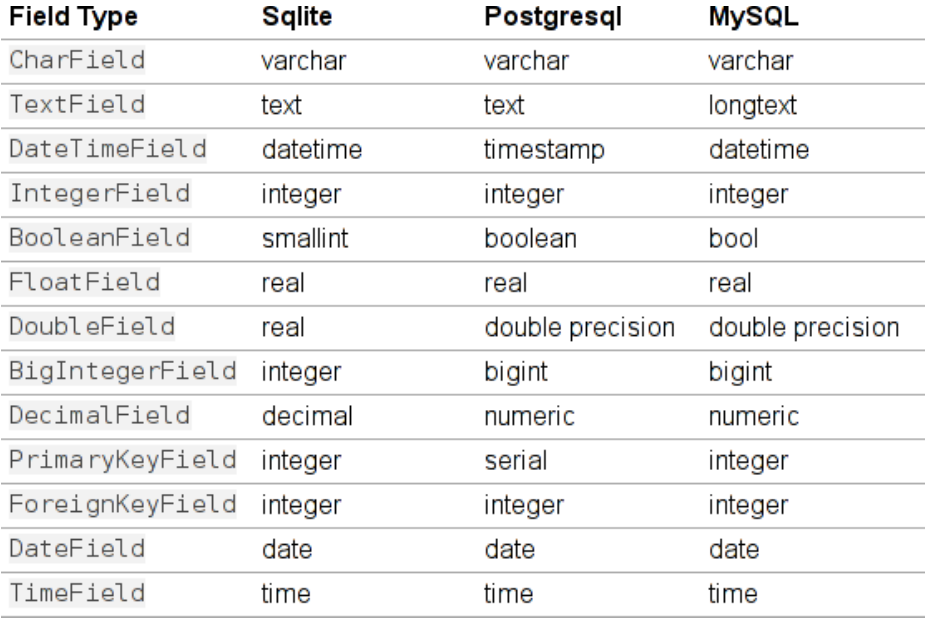

Creamos registros
-----------------

In [8]:
u0 = User()
u0.name = "Ramona Flowers"
u0.age = 24
u0.save()
u1 = User(name="Stephen Stills", age=24)
u1.save()
u2 = User(name="Scott Pilgrim", age=23)
u2.save()

1

## Queries 1


```sql
SELECT * FROM user
```

In [9]:
print("Todos los Usuarios")
for u in User.select():
    print(u.id, u.name, u.age)

Todos los Usuarios
1 Ramona Flowers 24
2 Stephen Stills 24
3 Scott Pilgrim 23


Queries 2
---------

```sql
SELECT * FROM user WHERE id = 1
```

In [15]:
print("Con ID=1")
user = User.get(User.id == 1)
print(type(user), user.id, user.name)

Con ID=1
<Model: User> 1 Ramona Flowers


Queries 3
---------

```sql
SELECT * FROM user WHERE name = 'Stephen Stills'
```

In [18]:
print("Con nombre 'Stephen Stills'")
usr = User.get(User.name == "Stephen Stills")
print(usr)

Con nombre 'Stephen Stills'
2


Queries 4
---------

```sql
SELECT * FROM user WHERE age <= 24
```

In [19]:
print("Con edad <= 24")
for u in User.filter(User.age <= 24):
    print(u.name)


Con edad <= 24
Ramona Flowers
Stephen Stills
Scott Pilgrim


Queries 5
---------

In [21]:
print("Con nombre que empieza con 'S'")
for u in User.filter(fn.Substr(User.name, 1, 1) == "S"):
    print(u.id, u.name)

Con nombre que empieza con 'S'
2 Stephen Stills
3 Scott Pilgrim


Queries 6 (Entran los autos)
----------------------------

In [24]:
# u0 -> Ramona Flowers
car = Car(model="2012", plate="aac 2502", user=u0)
car.save()

print("Autos de u0")
for c in u0.cars: # Car.filter(Car.user == u0)
    print("{} -> {}".format(c.plate, c.user.name))


Autos de u0
jbc 2502 -> Ramona Flowers
aac 2502 -> Ramona Flowers


Queries 7
---------

In [26]:
print("Cantidad de autos de personas con 24 años")

print(
    Car.select().join(
        User
    ).where(
        User.age == 24
    ).count()
)

Cantidad de autos de personas con 24 años
2


Queries 8
---------

In [28]:
print("Autos con modelo 2012 de usuarios de 24 años")
for car in Car.select().join(User).where(User.age == 24, Car.model=="2012"):
    print(car.plate, "--", car.model)

Autos con modelo 2012 de usuarios de 24 años
jbc 2502 -- 2012
aac 2502 -- 2012


Update and Delete
-----------------

**UPDATE**


In [29]:
print("Una actualización")
c = Car.get(plate="jbc 2502")
c.plate = "AAC 6666"
c.save()

Una actualización


1

**DELETE**

In [30]:
print(u0.cars.count())
car0.delete_instance()
print(u0.cars.count())

2


NameError: name 'car0' is not defined

Cosas en el tintero
-------------------

- ``.order_by``
- ``.having``
- ``.group_by``    